# Guidance

This tutorial demonstrates how to perform guidance with a pre-trained denoiser.

In [1]:
import math
import matplotlib.pyplot as plt
import torch

from torch import Tensor
from torch.distributions import Normal

from azula.denoise import Gaussian, GaussianDenoiser
from azula.guidance import DiffPIRDenoiser, DPSSampler, MMPSDenoiser, TDSSampler, TMPDenoiser
from azula.noise import RectifiedSchedule
from azula.sample import DDIMSampler, PCSampler

device = "cpu"

In [2]:
_ = torch.manual_seed(1)

In [3]:
def smooth_manifold(
    shape: tuple = (),
    m: int = 1,
    n: int = 3,
    alpha: float = 3.0,
    epsilon: float = 1e-3,
) -> Tensor:
    r"""Samples points from a smooth random manifold.

    References:
        https://github.com/fzenke/randman

    Arguments:
        m: The manifold dimension.
        n: The space dimension.
        alpha: The smoothness coefficient.
    """

    cutoff = math.ceil(epsilon ** (-1 / alpha))
    k = torch.arange(cutoff) + 1

    a, b, c = torch.rand(3, n, m, cutoff)

    z = torch.rand(*shape, 1, m, 1)
    x = a / k**alpha * torch.sin(2 * math.pi * (k * b * z + c))
    x = torch.sum(x, dim=-1)
    x = torch.prod(x, dim=-1)

    return x

In [4]:
m = 5
loc = []

for _ in range(2):
    x = smooth_manifold((256,), 1, m)
    x = (x - x.min(dim=0).values) / (x.max(dim=0).values - x.min(dim=0).values)
    x = x * 4 - 2

    loc.append(x)

loc = torch.cat(loc).to(device)
scale = torch.tensor([0.05] * m).to(device)

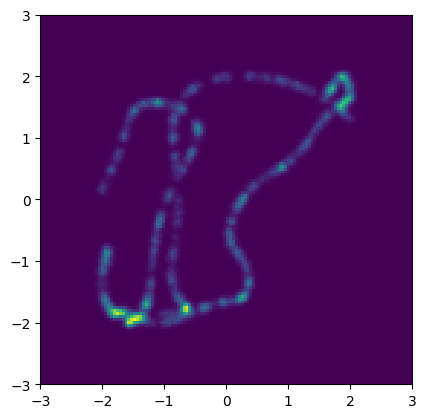

In [5]:
x = Normal(loc, scale).sample((256,))
x = x.reshape(-1, loc.shape[-1])

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(
    x[..., 0].cpu(),
    x[..., 1].cpu(),
    bins=128,
    range=((-3, 3), (-3, 3)),
)
plt.show()

## Measurement

In [6]:
H = torch.randn(m, 2).to(device)
A = lambda x: x @ H
sigma_y = 1
y = torch.normal(A(x[0]), sigma_y)

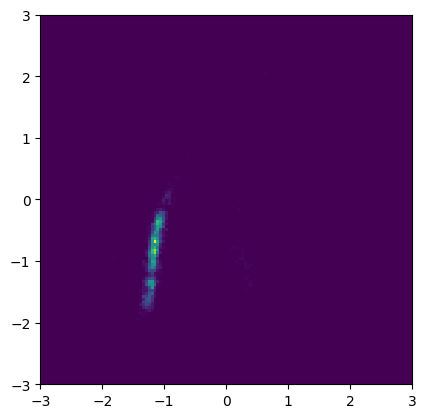

In [7]:
log_w = Normal(A(x), sigma_y).log_prob(y).sum(dim=-1)
w = torch.softmax(log_w, dim=0)
i = torch.multinomial(w, 4096, replacement=True)

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(
    x[i, 0].cpu(),
    x[i, 1].cpu(),
    bins=128,
    range=((-3, 3), (-3, 3)),
)
plt.show()

## GMM diffusion model

In [8]:
class GMMDenoiser(GaussianDenoiser):
    def __init__(self, loc: Tensor, scale: Tensor):
        super().__init__()

        self.schedule = RectifiedSchedule()

        self.register_buffer("loc", loc)
        self.register_buffer("scale", scale)

    def log_prob(self, x_t: Tensor, t: Tensor) -> Tensor:
        alpha_t, sigma_t = self.schedule(t)

        loc_t = alpha_t * self.loc
        scale_t = torch.sqrt(alpha_t**2 * self.scale**2 + sigma_t**2)

        x_t = x_t.unsqueeze(-2)

        log_p = Normal(loc_t, scale_t, validate_args=False).log_prob(x_t)
        log_p = torch.sum(log_p, dim=-1)
        log_p = torch.logsumexp(log_p, dim=-1)

        return log_p

    def forward(self, x_t: Tensor, t: Tensor) -> Gaussian:
        alpha_t, sigma_t = self.schedule(t)
        score = torch.func.vmap(torch.func.grad(self.log_prob), in_dims=(0, None))(x_t, t)

        return Gaussian(
            mean=(x_t + sigma_t**2 * score) / alpha_t,
            var=sigma_t**2 / (alpha_t**2 + sigma_t**2),
        )


denoiser = GMMDenoiser(
    loc=loc,
    scale=scale,
).to(device)

## Diffusion Plug-and-Play Image Restoration (DiffPIR)

In [9]:
# cond_denoiser = DiffPIRDenoiser(denoiser, y=y, A=A, var_y=sigma_y**2, lmbda=1, iterations=1)
# cond_sampler = DDIMSampler(cond_denoiser, steps=64, eta=1.0).to(device)

# x1 = cond_sampler.init((1024, m))
# x0 = cond_sampler(x1)

# plt.figure(figsize=(4.8, 4.8))
# plt.hist2d(
#     x0[..., 0].cpu(),
#     x0[..., 1].cpu(),
#     bins=128,
#     range=((-3, 3), (-3, 3)),
# )
# plt.show()

## Diffusion Posterior Sampling (DPS)

In [10]:
# cond_sampler = DPSSampler(denoiser, y=y, A=A, steps=64).to(device)

# x1 = cond_sampler.init((1024, m))
# x0 = cond_sampler(x1)

# plt.figure(figsize=(4.8, 4.8))
# plt.hist2d(
#     x0[..., 0].cpu(),
#     x0[..., 1].cpu(),
#     bins=128,
#     range=((-3, 3), (-3, 3)),
# )
# plt.show()

## Twisted Diffusion Sampling (TDS)

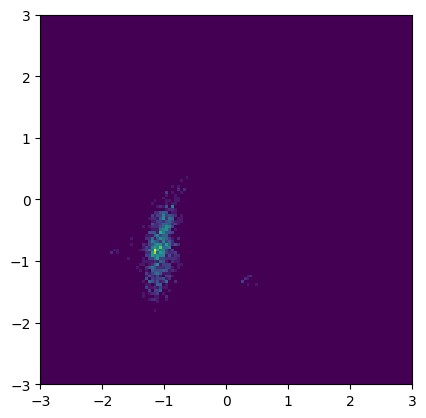

In [11]:
def log_p_y(x, t):
    return Gaussian(A(x), sigma_y**2 + t**2 * torch.diag(H.mT @ H)).log_prob(y)


cond_sampler = TDSSampler(denoiser, twist=log_p_y, steps=64, stop=0.1).to(device)

x1 = cond_sampler.init((1024, m))
x0 = cond_sampler(x1)

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(
    x0[..., 0].cpu(),
    x0[..., 1].cpu(),
    bins=128,
    range=((-3, 3), (-3, 3)),
)
plt.show()

## Tweedie Moment Projected Diffusion (TMPD)

In [12]:
# cond_denoiser = TMPDenoiser(denoiser, y=y, A=A, var_y=sigma_y**2)
# cond_sampler = DDIMSampler(cond_denoiser, steps=64, eta=1.0).to(device)

# x1 = cond_sampler.init((1024, m))
# x0 = cond_sampler(x1)

# plt.figure(figsize=(4.8, 4.8))
# plt.hist2d(
#     x0[..., 0].cpu(),
#     x0[..., 1].cpu(),
#     bins=128,
#     range=((-3, 3), (-3, 3)),
# )
# plt.show()

## Moment Matching Posterior Sampling (MMPS)

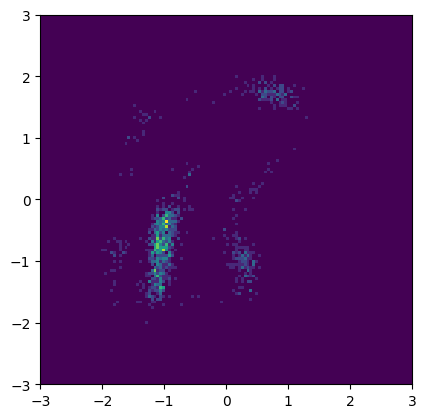

In [16]:
cond_denoiser = MMPSDenoiser(denoiser, y=y, A=A, var_y=sigma_y**2, iterations=1)
cond_sampler = DDIMSampler(cond_denoiser, steps=64, eta=1.0, stop=0.1).to(device)
# cond_sampler = PCSampler(cond_denoiser, steps=16, corrections=1, leaps=4, delta=0.1, stop=0.1).to(device)

x1 = cond_sampler.init((1024, m))
x0 = cond_sampler(x1)

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(
    x0[..., 0].cpu(),
    x0[..., 1].cpu(),
    bins=128,
    range=((-3, 3), (-3, 3)),
)
plt.show()